In [30]:
import pandas as pd

# Load CSV
df = pd.read_csv('synthetic_battery_prediction_data.csv')

# Features and targets
feature_cols = ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
target_cols = ['temperature_next', 'voltage_next', 'current_next']

X = df[feature_cols].values
y = df[target_cols].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1999, 7)
y shape: (1999, 3)


In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('synthetic_battery_prediction_data.csv')

# Features and targets
feature_cols = ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
target_cols = ['temperature_next', 'voltage_next', 'current_next']

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform
X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_cols])


In [32]:
import numpy as np

seq_length = 10  # number of timesteps per sequence

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # predict next step after the sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

print("X_seq shape:", X_seq.shape)  # (num_samples, seq_length, num_features)
print("y_seq shape:", y_seq.shape)  # (num_samples, num_targets)


X_seq shape: (1989, 10, 7)
y_seq shape: (1989, 3)


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=600, shuffle=False)


In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Split into train/validation/test (60/20/20)
dataset = TensorDataset(X_tensor, y_tensor)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train samples: 1193
Validation samples: 397
Test samples: 399


In [35]:
import torch.nn as nn

class BatteryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BatteryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)  # Additional dropout after LSTM
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)          # out: [batch, seq_len, hidden]
        out = out[:, -1, :]            # take last timestep
        out = self.dropout(out)        # Apply dropout
        out = self.fc(out)
        return out

input_size = X_seq.shape[2]   # number of features
hidden_size = 64
num_layers = 2
output_size = y_seq.shape[1]  # number of targets
dropout_rate = 0.2  # Dropout rate for regularization

model = BatteryLSTM(input_size, hidden_size, num_layers, output_size, dropout=dropout_rate)
print(f"Model created with dropout={dropout_rate}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created with dropout=0.2
Total parameters: 52,163


## Anti-Overfitting Techniques Applied

1. **Dropout Regularization** (0.2): Randomly drops 20% of neurons during training to prevent co-adaptation
2. **Weight Decay (L2)** (1e-5): Adds penalty to large weights to prevent overfitting
3. **Validation Set**: 60/20/20 split (train/val/test) to monitor generalization
4. **Early Stopping**: Stops training when validation loss doesn't improve for 10 epochs
5. **Learning Rate Scheduling**: Reduces learning rate when validation loss plateaus
6. **Loss Monitoring**: Tracks both training and validation loss to detect overfitting


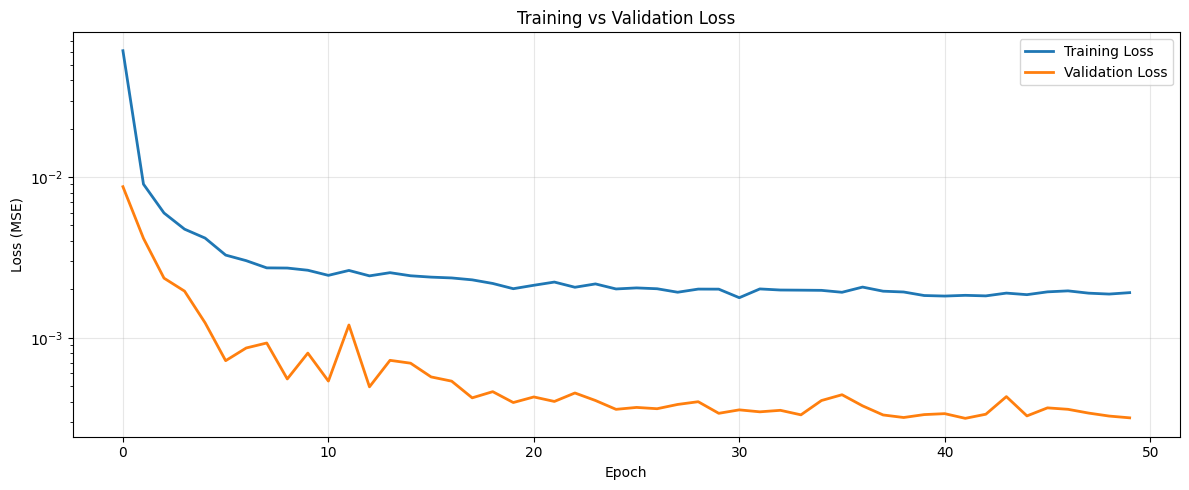


Final Training Loss: 0.001909
Final Validation Loss: 0.000317
Gap: -0.001592 (-83.39%)
✓ Good generalization - train and validation losses are close


In [36]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt

# Check if train_losses and val_losses exist (defined in training cell)
if 'train_losses' in globals() and 'val_losses' in globals():
    train_losses_list = globals()['train_losses']
    val_losses_list = globals()['val_losses']
    
    if len(train_losses_list) > 0 and len(val_losses_list) > 0:
        plt.figure(figsize=(12, 5))
        plt.plot(train_losses_list, label='Training Loss', linewidth=2)
        plt.plot(val_losses_list, label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')  # Log scale to better see the differences
        plt.tight_layout()
        plt.show()

        # Check for overfitting
        final_train_loss = train_losses_list[-1]
        final_val_loss = val_losses_list[-1]
        gap = final_val_loss - final_train_loss
        gap_percent = (gap / final_train_loss) * 100 if final_train_loss > 0 else 0
        
        print(f"\nFinal Training Loss: {final_train_loss:.6f}")
        print(f"Final Validation Loss: {final_val_loss:.6f}")
        print(f"Gap: {gap:.6f} ({gap_percent:.2f}%)")
        
        if gap_percent > 20:
            print("⚠️  Warning: Large gap indicates possible overfitting!")
        elif gap_percent > 10:
            print("⚠️  Moderate gap - model may be slightly overfitting")
        else:
            print("✓ Good generalization - train and validation losses are close")
    else:
        print("⚠️  train_losses and val_losses are empty. Please run the training cell (Cell 8) first.")
else:
    print("⚠️  Error: train_losses and val_losses are not defined.")
    print("Please run the training cell (Cell 8) first before visualizing the loss curves.")


In [37]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

criterion = nn.MSELoss()
# Add weight decay (L2 regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 30
patience = 10  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0

# Track losses for visualization
train_losses = []
val_losses = []

print("Starting training with validation monitoring...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:3d}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}", end="")
    
    if patience_counter == 0:
        print(" *")  # Best model marker
    else:
        print(f" (patience: {patience_counter}/{patience})")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Loading best model with validation loss: {best_val_loss:.6f}")
        model.load_state_dict(torch.load('best_model.pth'))
        break

print("-" * 60)
print("Training completed!")


Starting training with validation monitoring...
------------------------------------------------------------


c:\Users\hejer\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1/30 | Train Loss: 0.089505 | Val Loss: 0.012317 | LR: 0.001000 *
Epoch   2/30 | Train Loss: 0.011497 | Val Loss: 0.004021 | LR: 0.001000 *
Epoch   2/30 | Train Loss: 0.011497 | Val Loss: 0.004021 | LR: 0.001000 *
Epoch   3/30 | Train Loss: 0.006177 | Val Loss: 0.002556 | LR: 0.001000 *
Epoch   3/30 | Train Loss: 0.006177 | Val Loss: 0.002556 | LR: 0.001000 *
Epoch   4/30 | Train Loss: 0.005541 | Val Loss: 0.002067 | LR: 0.001000 *
Epoch   4/30 | Train Loss: 0.005541 | Val Loss: 0.002067 | LR: 0.001000 *
Epoch   5/30 | Train Loss: 0.004795 | Val Loss: 0.001383 | LR: 0.001000 *
Epoch   5/30 | Train Loss: 0.004795 | Val Loss: 0.001383 | LR: 0.001000 *
Epoch   6/30 | Train Loss: 0.004005 | Val Loss: 0.001672 | LR: 0.001000 (patience: 1/10)
Epoch   6/30 | Train Loss: 0.004005 | Val Loss: 0.001672 | LR: 0.001000 (patience: 1/10)
Epoch   7/30 | Train Loss: 0.003768 | Val Loss: 0.000807 | LR: 0.001000 *
Epoch   7/30 | Train Loss: 0.003768 | Val Loss: 0.000807 | LR: 0.001000 *
Epoch   

In [38]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions.append(outputs.numpy())
        actuals.append(yb.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse scale to original units
predictions_orig = scaler_y.inverse_transform(predictions)
actuals_orig = scaler_y.inverse_transform(actuals)

# RMSE
rmse = np.sqrt(np.mean((predictions_orig - actuals_orig)**2, axis=0))
print("RMSE for [temperature, voltage, current]:", rmse)


RMSE for [temperature, voltage, current]: [2.0498735e+01 1.2869023e-02 1.6321564e-02]


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# predictions_orig and actuals_orig from previous code
rmse = np.sqrt(mean_squared_error(actuals_orig, predictions_orig, multioutput='raw_values'))
mae = mean_absolute_error(actuals_orig, predictions_orig, multioutput='raw_values')
r2 = r2_score(actuals_orig, predictions_orig, multioutput='raw_values')

print("Temperature, Voltage, Current Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Temperature, Voltage, Current Metrics:
RMSE: [2.0498735e+01 1.2869023e-02 1.6321564e-02]
MAE: [1.7431124e+01 1.0003992e-02 1.3230324e-02]
R²: [0.9987858  0.99794894 0.9863515 ]


In [40]:
# Evaluate on validation set
model.eval()
val_predictions = []
val_actuals = []

with torch.no_grad():
    for xb, yb in val_loader:
        outputs = model(xb)
        val_predictions.append(outputs.numpy())
        val_actuals.append(yb.numpy())

val_predictions = np.vstack(val_predictions)
val_actuals = np.vstack(val_actuals)

# Inverse scale to original units
val_predictions_orig = scaler_y.inverse_transform(val_predictions)
val_actuals_orig = scaler_y.inverse_transform(val_actuals)

# Calculate metrics for validation set
val_rmse = np.sqrt(mean_squared_error(val_actuals_orig, val_predictions_orig, multioutput='raw_values'))
val_mae = mean_absolute_error(val_actuals_orig, val_predictions_orig, multioutput='raw_values')
val_r2 = r2_score(val_actuals_orig, val_predictions_orig, multioutput='raw_values')

print("\nValidation Set Metrics:")
print("Temperature, Voltage, Current Metrics (Validation):")
print("RMSE:", val_rmse)
print("MAE:", val_mae)
print("R²:", val_r2)

print("\nTest Set Metrics:")


Validation Set Metrics:
Temperature, Voltage, Current Metrics (Validation):
RMSE: [2.0626411e+01 1.2298463e-02 1.6741119e-02]
MAE: [1.7340904e+01 9.4794389e-03 1.3137439e-02]
R²: [0.99880654 0.9982874  0.9872577 ]

Test Set Metrics:


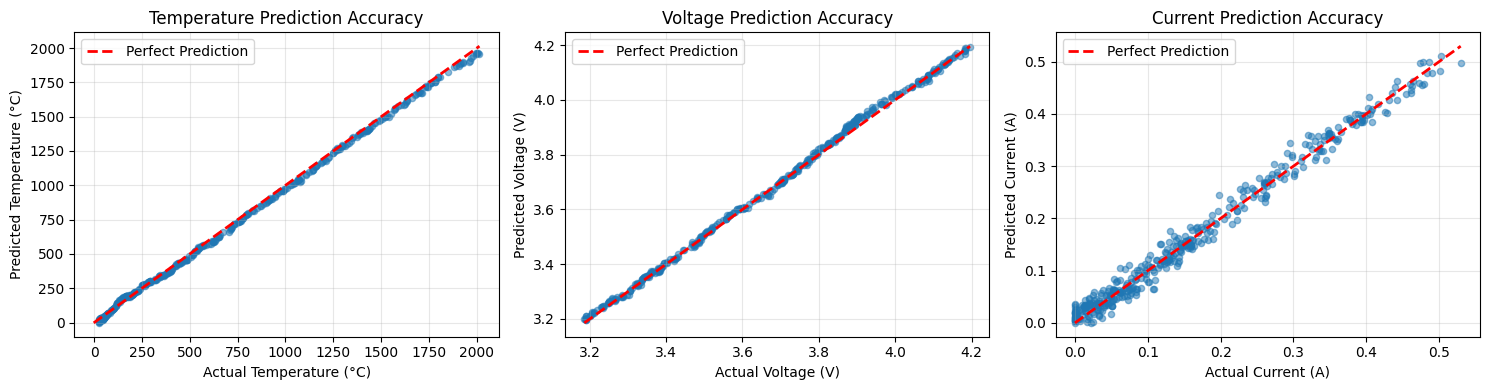

In [41]:
# Scatter plots for model evaluation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

targets = ['Temperature', 'Voltage', 'Current']
units = ['°C', 'V', 'A']

for idx, (target, unit) in enumerate(zip(targets, units)):
    axes[idx].scatter(actuals_orig[:, idx], predictions_orig[:, idx], alpha=0.5, s=20)
    # Perfect prediction line
    min_val = min(actuals_orig[:, idx].min(), predictions_orig[:, idx].min())
    max_val = max(actuals_orig[:, idx].max(), predictions_orig[:, idx].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel(f'Actual {target} ({unit})')
    axes[idx].set_ylabel(f'Predicted {target} ({unit})')
    axes[idx].set_title(f'{target} Prediction Accuracy')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [42]:
# Save the trained model and scalers
import torch
import pickle

# Save model
torch.save(model.state_dict(), 'battery_lstm_model.pth')
print("Model saved as 'battery_lstm_model.pth'")

# Save scalers
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

# Save model parameters for future loading
model_params = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'seq_length': seq_length
}

with open('model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)
print("Model parameters saved as 'model_params.pkl'")


Model saved as 'battery_lstm_model.pth'
Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'
Model parameters saved as 'model_params.pkl'


In [ ]:
# Print summary statistics
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nDataset: {len(df)} samples")
print(f"Sequence length: {seq_length}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nModel Architecture:")
print(f"  - Input features: {input_size}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - LSTM layers: {num_layers}")
print(f"  - Output size: {output_size}")
print(f"\nPerformance Metrics:")
print(f"  Temperature - RMSE: {rmse[0]:.4f} °C, MAE: {mae[0]:.4f} °C, R²: {r2[0]:.4f}")
print(f"  Voltage     - RMSE: {rmse[1]:.6f} V,  MAE: {mae[1]:.6f} V,  R²: {r2[1]:.4f}")
print(f"  Current     - RMSE: {rmse[2]:.6f} A,  MAE: {mae[2]:.6f} A,  R²: {r2[2]:.4f}")
print("="*60)



MODEL PERFORMANCE SUMMARY

Dataset: 1999 samples
Sequence length: 10
Training samples: 1193
Test samples: 399

Model Architecture:
  - Input features: 7
  - Hidden size: 64
  - LSTM layers: 2
  - Output size: 3

Performance Metrics:
  Temperature - RMSE: 20.4987 °C, MAE: 17.4311 °C, R²: 0.9988
  Voltage     - RMSE: 0.012869 V,  MAE: 0.010004 V,  R²: 0.9979
  Current     - RMSE: 0.016322 A,  MAE: 0.013230 A,  R²: 0.9864


: 